# CHECKEN VOOR INLEVERING

- Is context uitgebreid genoeg?
- Zijn de aannames compleet?
- Worden alle aannames verdedigd?
- "De stroom aan nieuwe COVID-patiënten is redelijk consistent; er is geen sprake van vlagen in bepaalde seizoenen." -> klopt dit?
- Tijdspanne inderdaad 3 maanden? En hoe groot is elke tijdstap in de simulatie?
-

# Setup

## Imports

In [24]:
# Imports
import pandas as pd
import itertools

from IPython.display import Image

## Configs

Hier kunnen we bepalen welke verschillende configuraties we willen testen, en genereren op basis daarvan alle configuratie-mogelijkheden.
We willen testen met een totale bedcapaciteit van 20-40 bedden (wat als indicatie gegeven werd door de opdrachtgever) en een totaal van 5 (alle) verschillende specialisaties. Het probleem dat hierdoor ontstaat, is dat er te veel mogelijke combinaties bestaan van verschillende bedconfiguraties (50,000+). Om dit probleem tegen te gaan, beperken we het aantal mogelijke combinaties door bedcapaciteit steeds met 5 te verhogen en het aantal bedden van minder belangrijke specialisaties minder vaak mogen voorkomen in de combinaties.

In [29]:
# Genereer alle mogelijke verdelingen van bedtype die optellen tot de bedcapaciteit
def generate_configurations(bed_capacity_range, num_specializations, max_occurrence):
    configurations = []
    for capacity in bed_capacity_range:
        for beds_distribution in itertools.combinations_with_replacement(range(capacity + 1), num_specializations):
            if sum(beds_distribution) <= capacity:
                config = {}
                valid_config = True

                for i, beds in enumerate(beds_distribution, start=1):
                    bed_type = f'Specialisatie_{i}'
                    max_percentage = max_occurrence.get(bed_type, 1)  # Standaard 100% als niet gespecificeerd
                    if beds / capacity <= max_percentage:
                        config[bed_type] = beds
                    else:
                        valid_config = False
                        break

                if valid_config:
                    generic_beds = capacity - sum(beds_distribution)
                    config['Generiek'] = generic_beds
                    configurations.append(config)

    return configurations

# Parameters instellen
bed_capacity_range = range(20, 41, 5)  # AANTAL BEDDEN in stappen van 5
num_specializations = 5               # AANTAL TYPE BEDDEN (INCL. GENERIEK)
max_occurrence = {'Generiek': 1, 'Specialisatie_2': 0.6, 'Specialisatie_3': 0.2, 'Specialisatie_4': 0.2, 'Specialisatie_5': 0.2}  # Maximale percentages

configurations = generate_configurations(bed_capacity_range, num_specializations, max_occurrence)

# Toon aantal configuraties
len(configurations)

2919

## Prepareren Data

In [27]:
# Kolommen en dummy-rij definiëren
columns = ["Configuratie_ID", "Bedcapaciteit", "Aantal_GeneriekBed", "Aantal_InfectieBed",
           "Aantal_ABed", "Aantal_BBed", "Aantal_CBed", "Bezettingsgraad",
           "Aantal_Afwijzingen", "Aantal_Geplande_Patienten", "Aantal_Ongeplande_Patienten",
           "Aantal_Herplande_Patienten", "Gemiddelde_Verblijfsduur", "Max_Bezettingsgraad",
           "Simulatie_Stappen"]

dummy_data = [["Config_00", 25, 5, 8, 4, 4, 4, "75%", 69, 21, 420, 4, 666, "95%", 10000]]

# Aanmaken Pandas dataframe en deze opslaan als CSV
df = pd.DataFrame(dummy_data, columns=columns)
df.to_csv('Analysis.csv', index=False)

df.head()

,Configuratie_ID,Bedcapaciteit,Aantal_GeneriekBed,Aantal_InfectieBed,Aantal_ABed,Aantal_BBed,Aantal_CBed,Bezettingsgraad,Aantal_Afwijzingen,Aantal_Geplande_Patienten,Aantal_Ongeplande_Patienten,Aantal_Herplande_Patienten,Gemiddelde_Verblijfsduur,Max_Bezettingsgraad,Simulatie_Stappen
0,Config_00,25,5,8,4,4,4,75%,69,21,420,4,666,95%,10000


## Runnen Simulaties

# Functies

Hier worden alle benodigde functies gemaakt voor het visualiseren van data uit onze simulatie. Sla voor de resultaten rustig deze sectie over.

## Staafdiagram

## Lijngrafiek

## Boxplot

## Scatterplot

## Heatmap

## Radar Chart?

# Inleiding

In deze Jupyter Notebook zullen we een diepgaande data-analyse uitvoeren op de resultaten verkregen uit onze ziekenhuis-simulatie. Het doel is om hieruit inzicht te krijgen over de optimale beddenconfiguratie om de bezettingsgraad van bedden zo hoog mogelijk te houden, maar ook het aantal afwijzingen te minimaliseren. Op basis van de resultaten geven wij een advies over de ideale beddenconfiguratie.

## Context

Ziekenhuizen beschikken over zowel aandoening-specifieke als generieke IC-bedden. Zo kan er een ruimte zijn met bedden die gereserveerd is voor patiënten met COVID-19, en een ruimte met generieke (alle overige) aandoeningen.
Het voordeel van generieke bedden is dat elk type patiënt hier in kan liggen; de kans op afwijzing van een nieuwe patiënt wordt daardoor kleiner, omdat er enkel geen plek meer zou zijn als elk bed in het ziekenhuis bezet is. Het nadeel is echter dat een patiënt met COVID niet in de ruimte bij niet-COVID patiënten mag liggen wegens kans op besmetting.
Daarom is aan ons de taak de optimale beddenconfiguratie te bepalen, zodat bedden goed benut worden zonder veel mensen af te moeten wijzen.

## Aannames

- Er worden niet met bedden geschoven tussen verschillende afdelingen.
- De stroom aan nieuwe COVID-patiënten is redelijk consistent; er is geen sprake van vlagen in bepaalde seizoenen.
- Het aantal beschikbare bedden staat vanaf het begin van de simulatie vast.
- Zodra een patiënt is ontslagen uit het ziekenhuis, komt zijn bed onmiddellijk vrij.
- Ongeplande patiënten krijgen voorrang op geplande patiënten.
- Mensen met infectie komen in een daarvoor-bestemde afdeling terecht.
- Er wordt geen onderscheid gemaakt tussen COVID-patiënten en patiënten met andere infecties

## Modelleerkeuzes

### Finite State Machine

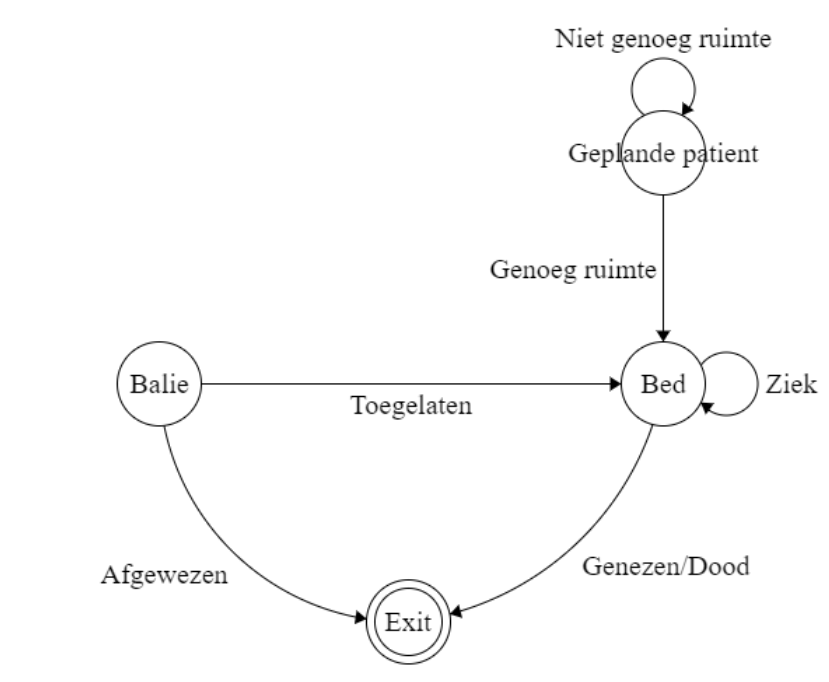

In [28]:
Image(filename='FSM.png')

Wij kiezen ervoor om in ons model gebruik te maken van een FSM, aangezien er duidelijk definieerbare discrete staten zijn waarin agents zich verkeren. Het aantal states is dan ook vrij beperkt en goed te doen. Zie hierboven hoe onze Finite State Machine eruitziet.

### Tijdspanne

We zullen een periode van 3 maanden simuleren om zo een goed beeld te krijgen van de bezettingsgraad en het aantal afwijzingen over de tijd heen, maar de simulatie snel genoeg draait om hem meerdere malen uit te kunnen voeren.

### Aanpasbare parameters / Te testen configuraties

Om met onze simulatie tot een volwaardige conclusie te komen, zijn er een verschillende parameters waar we mee willen experimenteren en analyse op uit willen voeren. Deze luiden als volgt:

- Bedconfiguratie (verdeling bedden over 5 verschillende afdelingen)
- Totale bedcapaciteit (20-40 bedden)